## Setup

In [115]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from scipy.ndimage import rotate


In [116]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

np.set_printoptions(suppress=True)

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
# Defining constant variables
TRAIN_PATH = '/content/drive/MyDrive/Bundesliga/train.csv'
POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/'
NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Negatives/'
GRAY_POSITIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/PositiveGray/'
GRAY_NEGATIVES_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/NegativeGray/'

## Defining functions

In [119]:
def create_df_events():
  """Reads original DataFrame and creates antoher one with only relevant events"""
  df = pd.read_csv(TRAIN_PATH)
  df_events = df[~df['event_attributes'].isna()].copy()
  df_events.reset_index(drop=True, inplace=True)
  return df, df_events

In [120]:
def create_train_test_video_ids(df_events, train_size):
  """Creates two arrays with which videos are either part of the train or the test data"""
  video_ids = df_events['video_id'].unique().tolist()
  amount_videos = len(video_ids)
  amount_train = round(amount_videos * train_size)
  train_videos = video_ids[:amount_train]
  test_videos = video_ids[amount_train:]
  return video_ids, train_videos, test_videos

In [121]:
def create_X(video_ids, negatives, gray):
  """Creates X array with all pictures for both train and test data"""
  X = list()
  POS_PATH, NEG_PATH = POSITIVES_FOLDER_PATH, NEGATIVES_FOLDER_PATH
  if gray:
    POS_PATH, NEG_PATH = GRAY_POSITIVES_FOLDER_PATH, GRAY_NEGATIVES_FOLDER_PATH
  for video_id in video_ids:
    current_video = np.load(f'{POS_PATH}{video_id}.npz')
    current_video = current_video.f.arr_0
    X.append(current_video)
  if negatives:
    for video_id in video_ids:
      current_neg_video = np.load(f'{NEG_PATH}{video_id}.npz')
      current_neg_video = current_neg_video.f.arr_0
      X.append(current_neg_video)
  X = np.concatenate(X, axis=0)
  return X

In [122]:
def train_test_X_split(df_events, X, train_videos, test_videos):
  """Splits pictures in train and test data"""
  train_idx = df_events[df_events['video_id'].isin(train_videos)].index
  test_idx = df_events[df_events['video_id'].isin(test_videos)].index
  X_train = X[train_idx]
  X_test = X[test_idx]
  assert df_events.shape[0] == X_train.shape[0] + X_test.shape[0]
  return X_train, X_test, train_idx, test_idx

In [123]:
def train_test_y_split(df_events, train_idx, test_idx):
  """Creates DataFrame of labels for both train and test data using videos ids"""
  y_train = df_events[df_events.index.isin(train_idx)]['event'].to_frame()
  y_test = df_events[df_events.index.isin(test_idx)]['event'].to_frame()
  return y_train, y_test

In [124]:
def append_negatives(df_events, X, X_train, X_test, y_train, y_test, train_size):
  """Appends negative samples created to both train and both test datasets"""
  len_positives = df_events.shape[0]
  len_X = X.shape[0]
  len_negatives = len_X - len_positives

  START_IDX_NEGATIVES = df_events.shape[0]
  START_IDX_NEG_TEST = round(START_IDX_NEGATIVES + len_negatives * train_size)
  X_train_neg = X[START_IDX_NEGATIVES:START_IDX_NEG_TEST]
  X_test_neg = X[START_IDX_NEG_TEST:]
  assert len_negatives == X_train_neg.shape[0] + X_test_neg.shape[0]

  X_train = np.concatenate((X_train, X_train_neg), axis=0)
  X_test = np.concatenate((X_test, X_test_neg), axis=0)

  y_train = y_train.append(pd.DataFrame({'event':['negative'] * X_train_neg.shape[0]}))
  y_train.reset_index(drop=True, inplace=True)
  y_test = y_test.append(pd.DataFrame({'event':['negative'] * X_test_neg.shape[0]}))
  return X_train, X_test, y_train, y_test

In [125]:
def create_array_to_drop_for_undersampling_in_play(y_train):
  """Creates array of indexes to drop and perform undersampling in column 'play'"""
  play_indexes = y_train[y_train['event'] == 'play'].index
  assert y_train.value_counts()['play'] == len(play_indexes)
  play_amount = y_train.value_counts()['play']
  challenge_amount = y_train.value_counts()['challenge']
  drop_play_indexes = np.sort(np.random.choice(a=play_indexes, 
                                              size=play_amount - challenge_amount, 
                                              replace=False))
  assert len(drop_play_indexes) == play_amount - challenge_amount
  return drop_play_indexes

In [126]:
def perform_undersampling(X_train, y_train, drop_play_indexes):
  """Performs undersampling in 'play' category to balance it with 'challenge'"""
  X_train = np.delete(X_train, drop_play_indexes, axis=0) # Numpy array
  y_train.drop(drop_play_indexes, axis=0, inplace=True) # Pandas DataFrame
  return X_train, y_train

In [127]:
def ordinal_encoding(y_train, y_test):
  """Performs ordinal encoding on our labels"""
  encoder = OrdinalEncoder()
  y_train = pd.Series(encoder.fit_transform(y_train).ravel())
  y_test = pd.Series(encoder.fit_transform(y_test).ravel())
  return y_train, y_test

In [128]:
def train_val_split(X_train, y_train, train_size):
  """Splits train data into train and validation sets"""
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=train_size, random_state=0)
  return X_train, X_val, y_train, y_val

In [129]:
def del_X(X):
  """Deletes heavy variable X to free RAM"""
  del X

In [130]:
def preprocessing(train_test_ratio=0.75, train_val_ratio=0.8, negatives=True, undersampling=False, gray=False, free_ram=True):
  """Runs the whole pipeline before building the model"""
  df, df_events = create_df_events()
  video_ids, train_videos, test_videos = create_train_test_video_ids(df_events, train_test_ratio)
  X = create_X(video_ids, negatives, gray)
  X_train, X_test, train_idx, test_idx = train_test_X_split(df_events, X, train_videos, test_videos)
  y_train, y_test = train_test_y_split(df_events, train_idx, test_idx)
  if negatives:
    X_train, X_test, y_train, y_test = append_negatives(df_events, X, X_train, X_test, y_train, y_test, train_test_ratio)
  if undersampling:
    drop_play_indexes = create_array_to_drop_for_undersampling_in_play(y_train)
    X_train, y_train = perform_undersampling(X_train, y_train, drop_play_indexes)
  y_train, y_test = ordinal_encoding(y_train, y_test)
  X_train, X_val, y_train, y_val = train_val_split(X_train, y_train, train_val_ratio)
  if free_ram:
    del_X(X)
  return X_train, X_val, X_test, y_train, y_val, y_test

In [131]:
def build_model(X_train, y_train, architecture='AlexNet'):
  """Builds CNN architecture of the model"""
  input_shape = X_train.shape[1], X_train.shape[2], X_train.shape[3]
  num_classes = y_train.nunique()

  if architecture == 'AlexNet':
    model = Sequential([
        Rescaling(1/255, 
                  input_shape=input_shape),  

        Conv2D(filters=96, 
               kernel_size=(11, 11), 
               strides=(4, 4), 
               activation='relu'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=256, 
               kernel_size=(5, 5),
               strides=(3, 3), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=384, 
               kernel_size=(3, 3),
               strides=(2, 2), # (1, 1)
               activation='relu',
               padding='same'),

        BatchNormalization(),

        Conv2D(filters=256, 
               kernel_size=(3, 3),
               strides=(1, 1), 
               activation='relu',
               padding='same'),

        BatchNormalization(),

        MaxPooling2D(pool_size=(3, 3), 
                     strides=(2, 2)),

        Flatten(),

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(256, 
              activation='relu'),

        Dropout(0.5), 

        Dense(num_classes, 
              activation='softmax')
        ])

    return model

In [132]:
def compile_model(model, optimizer='adam'):
  """Compiles the model"""
  model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics='accuracy',
              )
  return model

In [133]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=16, patience=3, account_weights=False):
  """Trains the model"""
  callback = EarlyStopping(monitor='val_loss',
                         patience=patience,
                         restore_best_weights=True)
  
  if account_weights:
    weights = class_weight.compute_class_weight(class_weight='balanced',
                                                classes=np.unique(y_train),
                                                y=y_train)
    class_weights = dict()
    for i, value in enumerate(weights):
      class_weights[i] = value

  else:
    class_weights = None

  model.fit(X_train, 
            y_train, 
            validation_data=(X_val, y_val), 
            batch_size=batch_size, 
            epochs=epochs,
            class_weight=class_weights,
            callbacks=[callback])
  
  return model

## Building 1st baseline model - with negatives and without undersampling

In [31]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing()

In [23]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3156, 480, 640, 3),
 (790, 480, 640, 3),
 (1156, 480, 640, 3),
 (3156, 4),
 (790, 4),
 (1156, 4))

In [24]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 480, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 118, 158, 96)      34944     
                                                                 
 batch_normalization (BatchN  (None, 118, 158, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 78, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 26, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 26, 256)      1

In [26]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
198/198 [==============================] - 330s 2s/step - loss: 1.1150 - accuracy: 0.6606 - val_loss: 0.9144 - val_accuracy: 0.7063
Epoch 2/100
198/198 [==============================] - 319s 2s/step - loss: 0.9342 - accuracy: 0.7060 - val_loss: 0.8631 - val_accuracy: 0.7063
Epoch 3/100
198/198 [==============================] - 315s 2s/step - loss: 0.9363 - accuracy: 0.7037 - val_loss: 0.8906 - val_accuracy: 0.7063
Epoch 4/100
198/198 [==============================] - 316s 2s/step - loss: 0.8962 - accuracy: 0.7075 - val_loss: 0.8945 - val_accuracy: 0.7063
Epoch 5/100
198/198 [==============================] - 315s 2s/step - loss: 0.8866 - accuracy: 0.7066 - val_loss: 0.8719 - val_accuracy: 0.7051


In [27]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              2231
                 1.0             0.0         0.0               427
1.0              0.0             0.0         0.0               407
0.0              0.0             0.0         1.0                91
dtype: int64

In [28]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              797
                 1.0             0.0         0.0              180
1.0              0.0             0.0         0.0              119
0.0              0.0             0.0         1.0               60
dtype: int64

In [29]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [30]:
y_pred_test = model.predict(X_test)

37/37 [==============================] - 28s 752ms/step


In [31]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

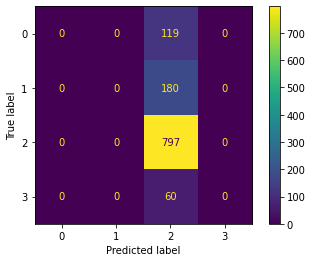

In [32]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [33]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2040


In [34]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

37/37 [==============================] - 27s 721ms/step - loss: 0.9714 - accuracy: 0.6894

Accuracy on the test set: 0.6894


In [ ]:
# model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_1')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_1')

## Building 2nd baseline model - with negatives and undersampling

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1358, 480, 640, 3),
 (340, 480, 640, 3),
 (1120, 480, 640, 3),
 (1358, 4),
 (340, 4),
 (1120, 4))

In [ ]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [ ]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
85/85 [==============================] - 159s 2s/step - loss: 1.7385 - accuracy: 0.3299 - val_loss: 1.2923 - val_accuracy: 0.3412
Epoch 2/100
85/85 [==============================] - 147s 2s/step - loss: 1.3104 - accuracy: 0.3387 - val_loss: 1.2839 - val_accuracy: 0.3147
Epoch 3/100
85/85 [==============================] - 143s 2s/step - loss: 1.2996 - accuracy: 0.3380 - val_loss: 1.2713 - val_accuracy: 0.3588
Epoch 4/100
85/85 [==============================] - 158s 2s/step - loss: 1.2760 - accuracy: 0.3623 - val_loss: 1.2653 - val_accuracy: 0.3529
Epoch 5/100
85/85 [==============================] - 145s 2s/step - loss: 1.2765 - accuracy: 0.3402 - val_loss: 1.2630 - val_accuracy: 0.3588
Epoch 6/100
85/85 [==============================] - 143s 2s/step - loss: 1.2534 - accuracy: 0.3292 - val_loss: 1.2629 - val_accuracy: 0.3588
Epoch 7/100
85/85 [==============================] - 141s 2s/step - loss: 1.2434 - accuracy: 0.3328 - val_loss: 1.2834 - val_accuracy: 0.3235
Epoch 

In [ ]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              1.0             0.0         0.0              465
                 0.0             1.0         0.0              402
1.0              0.0             0.0         0.0              401
0.0              0.0             0.0         1.0               90
dtype: int64

In [ ]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              797
                 1.0             0.0         0.0              144
1.0              0.0             0.0         0.0              119
0.0              0.0             0.0         1.0               60
dtype: int64

In [ ]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [ ]:
y_pred_test = model.predict(X_test)
y_pred_test

35/35 [==============================] - 27s 773ms/step


array([[0.00267016, 0.987425  , 0.00603648, 0.00386815],
       [0.00265423, 0.9873436 , 0.00611001, 0.00389227],
       [0.0039089 , 0.9808896 , 0.00985101, 0.00535036],
       ...,
       [0.29665706, 0.31993678, 0.29723728, 0.08616886],
       [0.2871848 , 0.33717072, 0.28238067, 0.09326389],
       [0.2772716 , 0.34768862, 0.29145598, 0.08358379]], dtype=float32)

In [ ]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

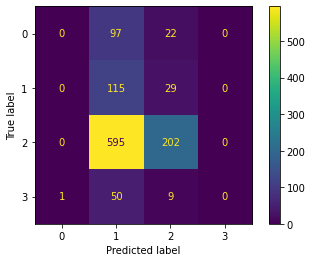

In [ ]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [ ]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.1528


In [ ]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

35/35 [==============================] - 27s 783ms/step - loss: 2.3058 - accuracy: 0.2830

Accuracy on the test set: 0.2830


In [ ]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_2')

## Building 3rd baseline model - with gray, with negatives, and with undersampling

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(undersampling=True, gray=True, train_test_ratio=0.83)

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1455, 480, 640, 3),
 (364, 480, 640, 3),
 (793, 480, 640, 3),
 (1455, 4),
 (364, 4),
 (793, 4))

In [ ]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [ ]:
model = train_model(model, X_train, y_train, X_val, y_val)

Epoch 1/100
90/90 [==============================] - 148s 2s/step - loss: 1.7618 - accuracy: 0.2937 - val_loss: 1.3163 - val_accuracy: 0.3278
Epoch 2/100
90/90 [==============================] - 147s 2s/step - loss: 1.3327 - accuracy: 0.3145 - val_loss: 1.3381 - val_accuracy: 0.3194
Epoch 3/100
90/90 [==============================] - 157s 2s/step - loss: 1.3067 - accuracy: 0.3396 - val_loss: 1.3208 - val_accuracy: 0.3167
Epoch 4/100
90/90 [==============================] - 145s 2s/step - loss: 1.3015 - accuracy: 0.3375 - val_loss: 1.3118 - val_accuracy: 0.2667
Epoch 5/100
90/90 [==============================] - 145s 2s/step - loss: 1.2789 - accuracy: 0.3354 - val_loss: 1.3108 - val_accuracy: 0.2972
Epoch 6/100
90/90 [==============================] - 144s 2s/step - loss: 1.2765 - accuracy: 0.3312 - val_loss: 1.3470 - val_accuracy: 0.2972
Epoch 7/100
90/90 [==============================] - 153s 2s/step - loss: 1.2743 - accuracy: 0.3396 - val_loss: 1.3098 - val_accuracy: 0.3139
Epoch 

In [ ]:
new_y_test = y_test.idxmax(axis=1)\
.replace({'event_challenge': 0, 'event_negative': 1, 'event_play': 2, 'event_throwin': 3})

In [ ]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 19s 747ms/step


In [ ]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

In [ ]:
y_train.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              1.0             0.0         0.0              477
                 0.0             1.0         0.0              436
1.0              0.0             0.0         0.0              430
0.0              0.0             0.0         1.0              112
dtype: int64

In [ ]:
y_test.value_counts()

event_challenge  event_negative  event_play  event_throwin
0.0              0.0             1.0         0.0              556
                 1.0             0.0         0.0              122
1.0              0.0             0.0         0.0               84
0.0              0.0             0.0         1.0               31
dtype: int64

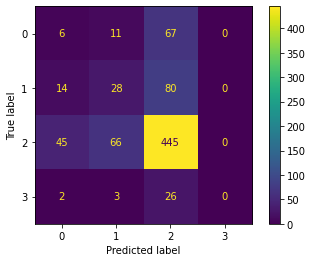

In [ ]:
ConfusionMatrixDisplay.from_predictions(new_y_test, y_pred_test_b)
plt.show()

In [ ]:
print(f"Macro F1 score: {f1_score(new_y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2703


In [ ]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

25/25 [==============================] - 19s 752ms/step - loss: 1.2495 - accuracy: 0.6040

Accuracy on the test set: 0.6040


In [ ]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_3')

## Building 4th baseline model - with gray, with negatives, without undersampling, and with class weights

In [19]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(gray=True, train_test_ratio=0.83)

In [91]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3447, 480, 640, 3),
 (862, 480, 640, 3),
 (793, 480, 640, 3),
 (3447,),
 (862,),
 (793,))

In [92]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [93]:
model = train_model(model, X_train, y_train, X_val, y_val, account_weights=True)

Epoch 1/100
216/216 [==============================] - 340s 2s/step - loss: 1.7715 - accuracy: 0.2823 - val_loss: 1.3761 - val_accuracy: 0.1566
Epoch 2/100
216/216 [==============================] - 333s 2s/step - loss: 1.4012 - accuracy: 0.0969 - val_loss: 1.4054 - val_accuracy: 0.0510
Epoch 3/100
216/216 [==============================] - 334s 2s/step - loss: 1.3922 - accuracy: 0.0673 - val_loss: 1.3864 - val_accuracy: 0.0302
Epoch 4/100
216/216 [==============================] - 333s 2s/step - loss: 1.3847 - accuracy: 0.1926 - val_loss: 1.3825 - val_accuracy: 0.6926


In [95]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 20s 763ms/step


In [96]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

In [97]:
y_train.value_counts()

2.0    2427
1.0     479
0.0     423
3.0     118
dtype: int64

In [98]:
y_test.value_counts()

2.0    556
1.0    122
0.0     84
3.0     31
dtype: int64

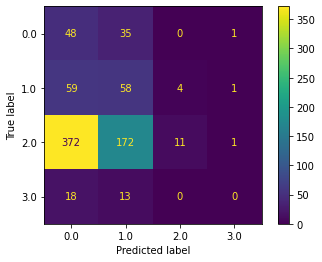

In [99]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_b)
plt.show()

In [100]:
print(f"Macro F1 score: {f1_score(y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.1234


In [101]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

25/25 [==============================] - 19s 768ms/step - loss: 1.3881 - accuracy: 0.1475

Accuracy on the test set: 0.1475


In [102]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_4')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_4')

## Building 5th baseline model - same as 4th, but patience=4

In [103]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(gray=True, train_test_ratio=0.83)

In [104]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3447, 480, 640, 3),
 (862, 480, 640, 3),
 (793, 480, 640, 3),
 (3447,),
 (862,),
 (793,))

In [105]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [106]:
model = train_model(model, X_train, y_train, X_val, y_val, account_weights=True, patience=4)

Epoch 1/100
216/216 [==============================] - 356s 2s/step - loss: 1.8086 - accuracy: 0.2588 - val_loss: 1.3945 - val_accuracy: 0.1230
Epoch 2/100
216/216 [==============================] - 350s 2s/step - loss: 1.3978 - accuracy: 0.2875 - val_loss: 1.4004 - val_accuracy: 0.0684
Epoch 3/100
216/216 [==============================] - 329s 2s/step - loss: 1.3879 - accuracy: 0.3525 - val_loss: 1.3796 - val_accuracy: 0.0267
Epoch 4/100
216/216 [==============================] - 333s 2s/step - loss: 1.3891 - accuracy: 0.1909 - val_loss: 1.3862 - val_accuracy: 0.0267
Epoch 5/100
216/216 [==============================] - 326s 2s/step - loss: 1.3879 - accuracy: 0.1540 - val_loss: 1.3823 - val_accuracy: 0.6995
Epoch 6/100
216/216 [==============================] - 327s 2s/step - loss: 1.3866 - accuracy: 0.1802 - val_loss: 1.3810 - val_accuracy: 0.6995
Epoch 7/100
216/216 [==============================] - 329s 2s/step - loss: 1.3947 - accuracy: 0.3780 - val_loss: 1.2661 - val_accuracy:

In [107]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 18s 705ms/step


In [108]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

In [109]:
y_train.value_counts()

2.0    2427
1.0     479
0.0     423
3.0     118
dtype: int64

In [110]:
y_test.value_counts()

2.0    556
1.0    122
0.0     84
3.0     31
dtype: int64

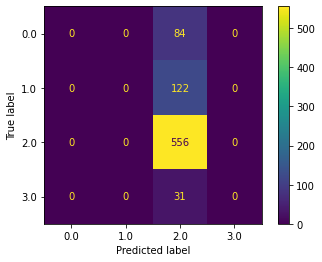

In [111]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_b)
plt.show()

In [112]:
print(f"Macro F1 score: {f1_score(y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2061


In [113]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

25/25 [==============================] - 21s 832ms/step - loss: 1.2702 - accuracy: 0.7011

Accuracy on the test set: 0.7011


In [114]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_5')

In [ ]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_5')

## Building 6th baseline model - same as 4th, without gray

In [135]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(train_test_ratio=0.83)

In [136]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3447, 480, 640, 3),
 (862, 480, 640, 3),
 (793, 480, 640, 3),
 (3447,),
 (862,),
 (793,))

In [137]:
model = build_model(X_train, y_train)
model = compile_model(model)

In [138]:
model = train_model(model, X_train, y_train, X_val, y_val, account_weights=True)

Epoch 1/100
216/216 [==============================] - 342s 2s/step - loss: 1.7994 - accuracy: 0.2637 - val_loss: 1.4481 - val_accuracy: 0.1381
Epoch 2/100
216/216 [==============================] - 332s 2s/step - loss: 1.4094 - accuracy: 0.1720 - val_loss: 1.4281 - val_accuracy: 0.1009
Epoch 3/100
216/216 [==============================] - 323s 1s/step - loss: 1.3924 - accuracy: 0.0983 - val_loss: 1.3972 - val_accuracy: 0.0476
Epoch 4/100
216/216 [==============================] - 333s 2s/step - loss: 1.3872 - accuracy: 0.1158 - val_loss: 1.3888 - val_accuracy: 0.0278
Epoch 5/100
216/216 [==============================] - 321s 1s/step - loss: 1.3860 - accuracy: 0.3104 - val_loss: 1.3801 - val_accuracy: 0.6485
Epoch 6/100
216/216 [==============================] - 330s 2s/step - loss: 1.3868 - accuracy: 0.4186 - val_loss: 1.4049 - val_accuracy: 0.4571
Epoch 7/100
216/216 [==============================] - 323s 1s/step - loss: 1.3982 - accuracy: 0.2901 - val_loss: 1.3761 - val_accuracy:

In [140]:
y_pred_test = model.predict(X_test)

25/25 [==============================] - 22s 858ms/step


In [141]:
y_pred_test_b = [np.argmax(i, axis=0) for i in y_pred_test]

In [142]:
y_train.value_counts()

2.0    2427
1.0     479
0.0     423
3.0     118
dtype: int64

In [143]:
y_test.value_counts()

2.0    556
1.0    122
0.0     84
3.0     31
dtype: int64

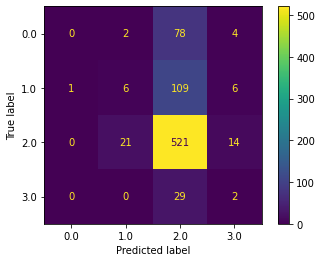

In [144]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_b)
plt.show()

In [152]:
print(f'{(1000/200):.4f}')

5.0000


In [154]:
print(f'True: 0\n0: {(0 / 84):.4f}, 1: {(2 / 84):.4f}, 2: {(78 / 84):.4f}, 0: {(4 / 84):.4f}')
print(f'True: 1\n0: {(0 / 122):.4f}, 1: {(6 / 122):.4f}, 2: {(109 / 122):.4f}, 0: {(6 / 122):.4f}')
print(f'True: 2\n0: {(0 / 556):.4f}, 1: {(21 / 556):.4f}, 2: {(521 / 556):.4f}, 0: {(14 / 556):.4f}')
print(f'True: 3\n0: {(0 / 31):.4f}, 1: {(0 / 31):.4f}, 2: {(29 / 31):.4f}, 0: {(2 / 31):.4f}')

True: 0
0: 0.0000, 1: 0.0238, 2: 0.9286, 0: 0.0476
True: 1
0: 0.0000, 1: 0.0492, 2: 0.8934, 0: 0.0492
True: 2
0: 0.0000, 1: 0.0378, 2: 0.9371, 0: 0.0252
True: 3
0: 0.0000, 1: 0.0000, 2: 0.9355, 0: 0.0645


In [149]:
print(classification_report(y_test, y_pred_test_b))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        84
         1.0       0.21      0.05      0.08       122
         2.0       0.71      0.94      0.81       556
         3.0       0.08      0.06      0.07        31

    accuracy                           0.67       793
   macro avg       0.25      0.26      0.24       793
weighted avg       0.53      0.67      0.58       793



In [145]:
print(f"Macro F1 score: {f1_score(y_test, y_pred_test_b, average='macro'):.4f}")

Macro F1 score: 0.2389


In [146]:
INDEX_ACCURACY = 1
print(f'\nAccuracy on the test set: {model.evaluate(X_test, y_test)[INDEX_ACCURACY]:.4f}')

25/25 [==============================] - 19s 734ms/step - loss: 1.3787 - accuracy: 0.6671

Accuracy on the test set: 0.6671


In [147]:
model.save('/content/drive/MyDrive/Bundesliga/Models/baseline_model_6')

In [148]:
# model = load_model('/content/drive/MyDrive/Bundesliga/Models/baseline_model_6')

## Data Augmentation

#### Create new folders for augmented image files

In [ ]:
ROTATED_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Rotated/'
CROPPED_FOLDER_PATH = 'content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Cropped/'
FLIPPED_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Flipped/'
BRIGHTED_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Brighted/'
BINARIZED_FOLDER_PATH = '/content/drive/MyDrive/Bundesliga/PicsFromVids/CompressedPic/Binarized/'

In [ ]:
FOLDER_TO_CREATE = [ROTATED_FOLDER_PATH, CROPPED_FOLDER_PATH, FLIPPED_FOLDER_PATH, BRIGHTED_FOLDER_PATH, BINARIZED_FOLDER_PATH]

In [ ]:
def create_new_folder(folder_list):
  for folder in FOLDER_TO_CREATE:
    isExist = os.path.exists(folder)
    if not isExist:
      os.makedirs(folder)
      print(f"The new directory {folder.split('/')[-2]} has been created!")
    else: 
      print(f"The folder {folder.split('/')[-2]} already exist!\n")

#### Generate cropped images

In [ ]:
def random_crop_img(img, crop_size=(10, 10)):
    # This function return an image randomly croped
    assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w, h = img.shape[:2]
    x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
    img = img[y:y+crop_size[0], x:x+crop_size[1]]
    return img

#### Generate rotated images

In [ ]:
def rotate_img(img, angle, bg_patch=(5,5)):
    # This function return an image rotated
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
    else:
        bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img

#### Generate flipped images

In [ ]:
def flip_img(img):
  # This function return flipped the image
  return np.fliplr(img)

#### Generate augmented images visualization 

In [ ]:
def visualize_img(original, augmented):
    # This function return a vizualisation of the original and the augmented image
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)

#### Generate bright images  

In [ ]:
def bright_img(img, thresh):
  img_bright = (img > thresh) * img
  return img_bright

#### Generate binarized images  

In [ ]:
def binarization_img(img, thresh, maxval = 255):
  """Since True is regarded as 1 and False is regarded as 0, 
  when multiplied by 255 which is the Max value of uint8, 
  True becomes 255 (white) and False becomes 0 (black)."""
  im_bin = (img > thresh) * maxval
  return im_bin

#### Main function for data augmentation  

In [ ]:
def data_augmentation(X_train, random_crop=False, rotate=False, flip=False, visualize=False, bright=False, binary=False, save_file=False):

  create_new_folder(FOLDER_TO_CREATE)

  c_1 = 0
  r_1 = 0
  f_1 = 0
  b_1 = 0
  bi_1 = 0

  for img in X_train:

    if random_crop:
      crop_augmented = random_crop_img(img, crop_size=(400, 400))
      if visualize:
        visualize_img(img, crop_augmented)
      if save_file:
        np.savez(f'{CROPPED_FOLDER_PATH}crop_augmented_{c_1}')
        print(f'crop_augmented_{c_1} created')
      c_1 += 1 

    if rotate:
      rotated_augmented = rotate_img(img, 10, bg_patch=(5,5))
      if save_file:
        np.savez(f'{ROTATED_FOLDER_PATH}rot_augmented_{r_1}')
        print(f'rot_augmented_{r_1} created')
        r_1 += 1 

      if visualize:
        visualize_img(img, rotated_augmented)
    
    if flip:
      flip_augmented = flip_img(img)
      if save_file:
        np.savez(f'{FLIPPED_FOLDER_PATH}flip_augmented_{f_1}')
        print(f'flip_augmented_{f_1} created')
        f_1 += 1

      if visualize:
        visualize_img(img, flip_augmented)

    if bright:
      bright_augmented = bright_img(img, 80)
      if save_file:
        np.savez(f'{BRIGHTED_FOLDER_PATH}bright_augmented_{b_1}')
        print(f'bright_augmented_{b_1} created')
        b_1 += 1

      if visualize:
        visualize_img(img, bright_augmented)

    if binary:
      binary_augmented = binarization_img(img, thresh=150, maxval = 255)
      if save_file:
        np.savez(f'{BINARIZED_FOLDER_PATH}binary_augmented_{bi_1}')
        print(f'binary_augmented_{bi_1} created')
        bi_1 += 1

      if visualize:
        visualize_img(img, binary_augmented)

      print('\n')

In [ ]:
data_augmentation(X_train, random_crop=False, 
                           rotate=False, 
                           flip=True, 
                           visualize=False, 
                           bright=True, 
                           binary=True, 
                           save_file=True)

## Tolerances and new labelling

In [34]:
error_tolerances = {'challenge': [0.30, 0.40, 0.50, 0.60, 0.70],
                    'play': [0.15, 0.20, 0.25, 0.30, 0.35],
                    'throwin': [0.15, 0.20, 0.25, 0.30, 0.35]
}

In [45]:
events = [event for event in error_tolerances.keys()]

In [49]:
df, df_events = create_df_events()

In [50]:
df

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.150000,challenge,['ball_action_forced']
2,1606b0e6_0,202.765822,end,NaN
3,1606b0e6_0,210.124111,start,NaN
4,1606b0e6_0,210.870000,challenge,['opponent_dispossessed']
...,...,...,...,...
11213,ecf251d4_0,3056.587000,challenge,['opponent_dispossessed']
11214,ecf251d4_0,3058.072895,end,NaN
11215,ecf251d4_0,3068.280519,start,NaN
11216,ecf251d4_0,3069.547000,throwin,['pass']


In [65]:
new_events = list()
INDEX_TOL = 0
for row in df.values:
  if row[2] in error_tolerances:
    tolerance = error_tolerances[row[2]][INDEX_TOL] / 2
    new_events.append([row[0], row[1] - tolerance, 'start_' + row[2], row[3]])
    new_events.append([row[0], row[1] + tolerance, 'end_' + row[2], row[3]])
df = pd.concat([df, pd.DataFrame(new_events, columns=df.columns)])
df = df[~df['event'].isin(events)]
df = df.sort_values(['video_id', 'time']).reset_index(drop=True)

In [66]:
df

,video_id,time,event,event_attributes
0,1606b0e6_0,200.265822,start,NaN
1,1606b0e6_0,201.000000,start_challenge,['ball_action_forced']
2,1606b0e6_0,201.300000,end_challenge,['ball_action_forced']
3,1606b0e6_0,202.765822,end,NaN
4,1606b0e6_0,210.124111,start,NaN
...,...,...,...,...
15595,ecf251d4_0,3058.072895,end,NaN
15596,ecf251d4_0,3068.280519,start,NaN
15597,ecf251d4_0,3069.472000,start_throwin,['pass']
15598,ecf251d4_0,3069.622000,end_throwin,['pass']
